# 11.04.20

**Authors:** Miron Rogovets, Demid Afonichev, Maxim Shmakov

---

### Task 8.

Open __telco.dta__ file.


Dependent variable: _Customer category_

Predictors: select not less than 5 predictors, you can recode or modify the variables before you create a model. Make sure that the correlation between selected predictors is not high.

Use the multinomial logistic regression to analyze the data. 
1. Assess the quality of the model.
2. Which gradients are statistically significant? 
3. Interpret the influence of each predictor variable on the dependent variable. Please provide detailed interpretation using related risk ratio.
4. Create confusion matrix.
    - What is the percentage of correctly predicted cases by the model for each category of dependent variable?
    - Which category is predicted in the best way?
5. Analyze the case number 10.
    - To which category this customer really belongs to?
    - What is the probability that the customer will choose this category according to the model?
    - To which category should the customer belong to according to the model?

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

In [2]:
df = pd.read_stata('data/telco.dta')
print(df.shape)
df.head(3)

(1000, 42)


,region,tenure,age,marital,address,income,ed,employ,retire,gender,...,confer,ebill,loglong,logtoll,logequi,logcard,logwire,lninc,custcat,churn
0,Zone 2,13.0,44.0,Married,9.0,64.0,College degree,5.0,No,Male,...,No,No,1.308333,NaN,NaN,2.014903,NaN,4.158883,Basic service,Yes
1,Zone 3,11.0,33.0,Married,7.0,136.0,Post-undergraduate degree,5.0,No,Male,...,Yes,No,1.481605,3.032546,NaN,2.724580,3.575151,4.912655,Total service,Yes
2,Zone 3,68.0,52.0,Married,24.0,116.0,Did not complete high school,29.0,No,Female,...,Yes,No,2.898671,2.890372,NaN,3.409496,NaN,4.753590,Plus service,No


In [3]:
import pyreadstat
_, meta = pyreadstat.read_dta('data/telco.dta')
meta.column_names_to_labels

{'region': 'Geographic indicator',
 'tenure': 'Months with service',
 'age': 'Age in years',
 'marital': 'Marital status',
 'address': 'Years at current address',
 'income': 'Household income in thousands',
 'ed': 'Level of education',
 'employ': 'Years with current employer',
 'retire': 'Retired',
 'gender': 'Gender',
 'reside': 'Number of people in household',
 'tollfree': 'Toll free service',
 'equip': 'Equipment rental',
 'callcard': 'Calling card service',
 'wireless': 'Wireless service',
 'longmon': 'Long distance last month',
 'tollmon': 'Toll free last month',
 'equipmon': 'Equipment last month',
 'cardmon': 'Calling card last month',
 'wiremon': 'Wireless last month',
 'longten': 'Long distance over tenure',
 'tollten': 'Toll free over tenure',
 'equipten': 'Equipment over tenure',
 'cardten': 'Calling card over tenure',
 'wireten': 'Wireless over tenure',
 'multline': 'Multiple lines',
 'voice': 'Voice mail',
 'pager': 'Paging service',
 'internet': 'Internet',
 'callid': 'Ca

First, we should check the type of variables in our data

In [4]:
df.dtypes

region      category
tenure       float64
age          float64
marital     category
address      float64
income       float64
ed          category
employ       float64
retire      category
gender      category
reside       float64
tollfree    category
equip       category
callcard    category
wireless    category
longmon      float64
tollmon      float64
equipmon     float64
cardmon      float64
wiremon      float64
longten      float64
tollten      float64
equipten     float64
cardten      float64
wireten      float64
multline    category
voice       category
pager       category
internet    category
callid      category
callwait    category
forward     category
confer      category
ebill       category
loglong      float64
logtoll      float64
logequi      float64
logcard      float64
logwire      float64
lninc        float64
custcat     category
churn       category
dtype: object

Then we check if we have any missing values

In [5]:
df.isna().sum()[df.isna().sum() > 0]

logtoll    525
logequi    614
logcard    322
logwire    704
dtype: int64

Plot the distribution of variables to choose the strategy of filling missing values:

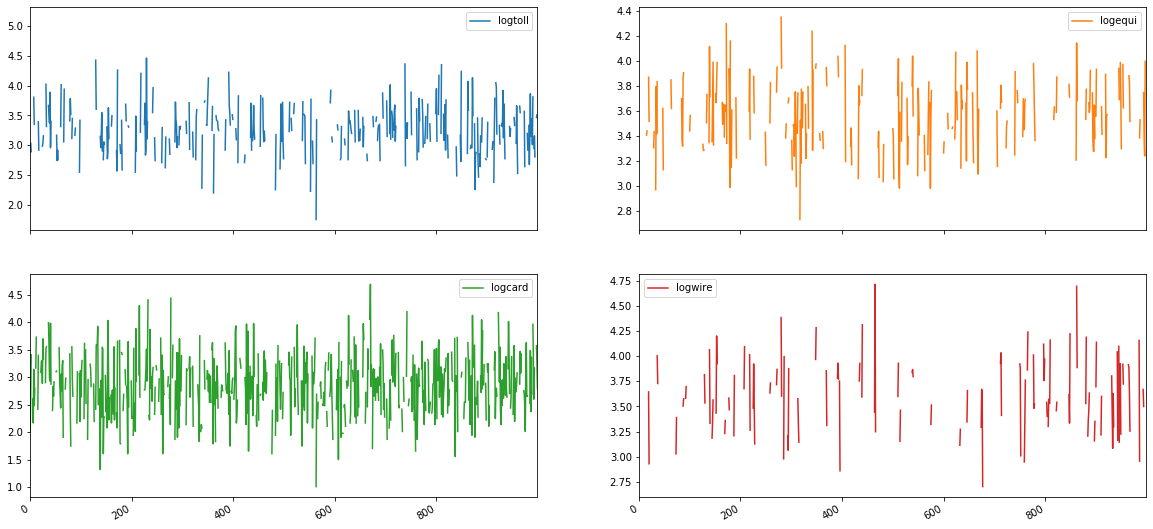

In [6]:
df[['logtoll', 'logequi', 'logcard', 'logwire']].plot(subplots=True, layout=(2,2), figsize=(20,10))
plt.show()

We can fill <code>nan</code> values with _means_

In [7]:
df.fillna(df.mean(), inplace=True)
df.head(3)

,region,tenure,age,marital,address,income,ed,employ,retire,gender,...,confer,ebill,loglong,logtoll,logequi,logcard,logwire,lninc,custcat,churn
0,Zone 2,13.0,44.0,Married,9.0,64.0,College degree,5.0,No,Male,...,No,No,1.308333,3.239705,3.568092,2.014903,3.598296,4.158883,Basic service,Yes
1,Zone 3,11.0,33.0,Married,7.0,136.0,Post-undergraduate degree,5.0,No,Male,...,Yes,No,1.481605,3.032546,3.568092,2.724580,3.575151,4.912655,Total service,Yes
2,Zone 3,68.0,52.0,Married,24.0,116.0,Did not complete high school,29.0,No,Female,...,Yes,No,2.898671,2.890372,3.568092,3.409496,3.598296,4.753590,Plus service,No


In [8]:
for col in df.dtypes[df.dtypes == 'category'].index:
    print('Unique values of variable "{}":'.format(col))
    print(df[col].value_counts())
    print('\n')

Unique values of variable "region":
Zone 3    344
Zone 2    334
Zone 1    322
Name: region, dtype: int64


Unique values of variable "marital":
Unmarried    505
Married      495
Name: marital, dtype: int64


Unique values of variable "ed":
High school degree              287
College degree                  234
Some college                    209
Did not complete high school    204
Post-undergraduate degree        66
Name: ed, dtype: int64


Unique values of variable "retire":
No     953
Yes     47
Name: retire, dtype: int64


Unique values of variable "gender":
Female    517
Male      483
Name: gender, dtype: int64


Unique values of variable "tollfree":
No     526
Yes    474
Name: tollfree, dtype: int64


Unique values of variable "equip":
No     614
Yes    386
Name: equip, dtype: int64


Unique values of variable "callcard":
Yes    678
No     322
Name: callcard, dtype: int64


Unique values of variable "wireless":
No     704
Yes    296
Name: wireless, dtype: int64


Unique values of 

In [9]:
df['custcat'] = df.custcat.apply(lambda x: x.split(' ')[0])
df['custcat'].unique()

[Basic, Total, Plus, E-service]
Categories (4, object): [Basic < E-service < Plus < Total]

In [10]:
df['region'] = df.region.apply(lambda x: x.replace(' ', ''))
df['region'].unique()

[Zone2, Zone3, Zone1]
Categories (3, object): [Zone1 < Zone2 < Zone3]

In [11]:
ed = {'High school degree' : 'school', 
      'College degree' : 'college',
      'Some college' : 'some',
      'Did not complete high school' : 'none',
      'Post-undergraduate degree' : 'higher'
     }
df['ed'] = df.ed.replace(ed).astype('category')
df['ed'].unique()

[college, higher, none, school, some]
Categories (5, object): [college, higher, none, school, some]

In [12]:
cols = df.dtypes[df.dtypes == 'category'].index.drop('custcat').values
data_encoded = pd.get_dummies(df, prefix=cols, columns=cols)
data_encoded.head()

,tenure,age,address,income,employ,reside,longmon,tollmon,equipmon,cardmon,...,callwait_No,callwait_Yes,forward_No,forward_Yes,confer_No,confer_Yes,ebill_No,ebill_Yes,churn_No,churn_Yes
0,13.0,44.0,9.0,64.0,5.0,2.0,3.70,0.00,0.0,7.50,...,1,0,0,1,1,0,1,0,0,1
1,11.0,33.0,7.0,136.0,5.0,6.0,4.40,20.75,0.0,15.25,...,0,1,0,1,0,1,1,0,0,1
2,68.0,52.0,24.0,116.0,29.0,2.0,18.15,18.00,0.0,30.25,...,0,1,1,0,0,1,1,0,1,0
3,33.0,33.0,12.0,33.0,0.0,1.0,9.45,0.00,0.0,0.00,...,1,0,1,0,1,0,1,0,0,1
4,23.0,30.0,9.0,30.0,2.0,4.0,6.30,0.00,0.0,0.00,...,1,0,0,1,0,1,1,0,1,0


In [13]:
data = data_encoded.drop(columns=['region_Zone3', 'marital_Unmarried', 'ed_none',
                                  'retire_No', 'gender_Female', 'tollfree_No',
                                  'equip_No', 'callcard_No', 'wireless_No',
                                  'multline_No', 'voice_No', 'pager_No',
                                  'internet_No', 'callid_No', 'callwait_No',
                                  'forward_No', 'confer_No', 'ebill_No', 'churn_No'
                                 ]).copy()
data.head()

,tenure,age,address,income,employ,reside,longmon,tollmon,equipmon,cardmon,...,multline_Yes,voice_Yes,pager_Yes,internet_Yes,callid_Yes,callwait_Yes,forward_Yes,confer_Yes,ebill_Yes,churn_Yes
0,13.0,44.0,9.0,64.0,5.0,2.0,3.70,0.00,0.0,7.50,...,0,0,0,0,0,0,1,0,0,1
1,11.0,33.0,7.0,136.0,5.0,6.0,4.40,20.75,0.0,15.25,...,0,1,1,0,1,1,1,1,0,1
2,68.0,52.0,24.0,116.0,29.0,2.0,18.15,18.00,0.0,30.25,...,0,0,0,0,1,1,0,1,0,0
3,33.0,33.0,12.0,33.0,0.0,1.0,9.45,0.00,0.0,0.00,...,0,0,0,0,0,0,0,0,0,1
4,23.0,30.0,9.0,30.0,2.0,4.0,6.30,0.00,0.0,0.00,...,0,0,0,0,1,0,1,1,0,0


In [14]:
data.rename(columns={'region_Zone1': 'zone1',
                     'region_Zone2': 'zone2',
                     'marital_Married': 'married',
                     'retire_Yes':'retire',
                     'gender_Male' : 'male',
                     'tollfree_Yes' : 'tollfree',
                     'equip_Yes' : 'equip',
                     'callcard_Yes' : 'callcard',
                     'wireless_Yes' : 'wireless',
                     'multline_Yes' : 'multline',
                     'voice_Yes' : 'voice',
                     'pager_Yes' : 'pager',
                     'internet_Yes' : 'internet',
                     'callid_Yes' : 'callid',
                     'callwait_Yes' : 'callwait',
                     'forward_Yes' : 'forward',
                     'confer_Yes' : 'confer',
                     'ebill_Yes' : 'ebill',
                     'churn_Yes' : 'churn',
                    }, inplace=True)
data.head()

,tenure,age,address,income,employ,reside,longmon,tollmon,equipmon,cardmon,...,multline,voice,pager,internet,callid,callwait,forward,confer,ebill,churn
0,13.0,44.0,9.0,64.0,5.0,2.0,3.70,0.00,0.0,7.50,...,0,0,0,0,0,0,1,0,0,1
1,11.0,33.0,7.0,136.0,5.0,6.0,4.40,20.75,0.0,15.25,...,0,1,1,0,1,1,1,1,0,1
2,68.0,52.0,24.0,116.0,29.0,2.0,18.15,18.00,0.0,30.25,...,0,0,0,0,1,1,0,1,0,0
3,33.0,33.0,12.0,33.0,0.0,1.0,9.45,0.00,0.0,0.00,...,0,0,0,0,0,0,0,0,0,1
4,23.0,30.0,9.0,30.0,2.0,4.0,6.30,0.00,0.0,0.00,...,0,0,0,0,1,0,1,1,0,0


We've cleaned up our data, now we can choose predictor variables:

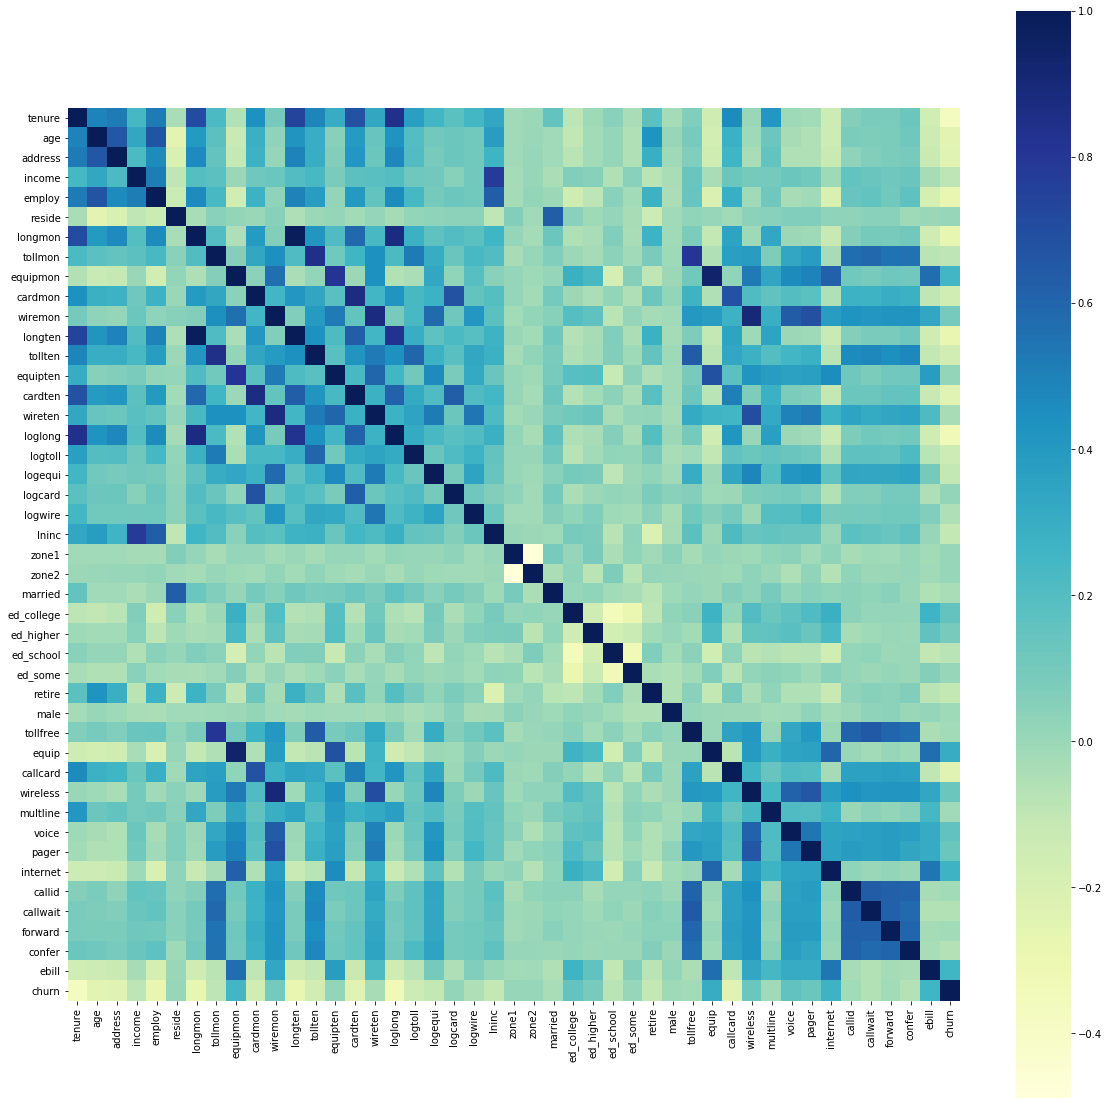

In [15]:
plt.figure(figsize=(20, 20))
sns.heatmap(data.corr(), square = True, cmap='YlGnBu')
plt.show()

In [16]:
data.drop(columns=['longmon', 'tollmon', 'equipmon', 'cardmon', 
                   'wiremon', 'churn', 'longten', 'tollten',
                   'equipten', 'cardten', 'wireten', 'reside',
                   'loglong', 'income', 'address', 'callwait',
                   'ebill', 'callid', 'forward', 'confer', 'employ',
                   'equip', 'wireless', 'pager', 'voice', 'multline'
                  ], inplace=True)
data.head(3)

,tenure,age,logtoll,logequi,logcard,logwire,lninc,custcat,zone1,zone2,married,ed_college,ed_higher,ed_school,ed_some,retire,male,tollfree,callcard,internet
0,13.0,44.0,3.239705,3.568092,2.014903,3.598296,4.158883,Basic,0,1,1,1,0,0,0,0,1,0,1,0
1,11.0,33.0,3.032546,3.568092,2.724580,3.575151,4.912655,Total,0,0,1,0,1,0,0,0,1,1,1,0
2,68.0,52.0,2.890372,3.568092,3.409496,3.598296,4.753590,Plus,0,0,1,0,0,0,0,0,0,1,1,0


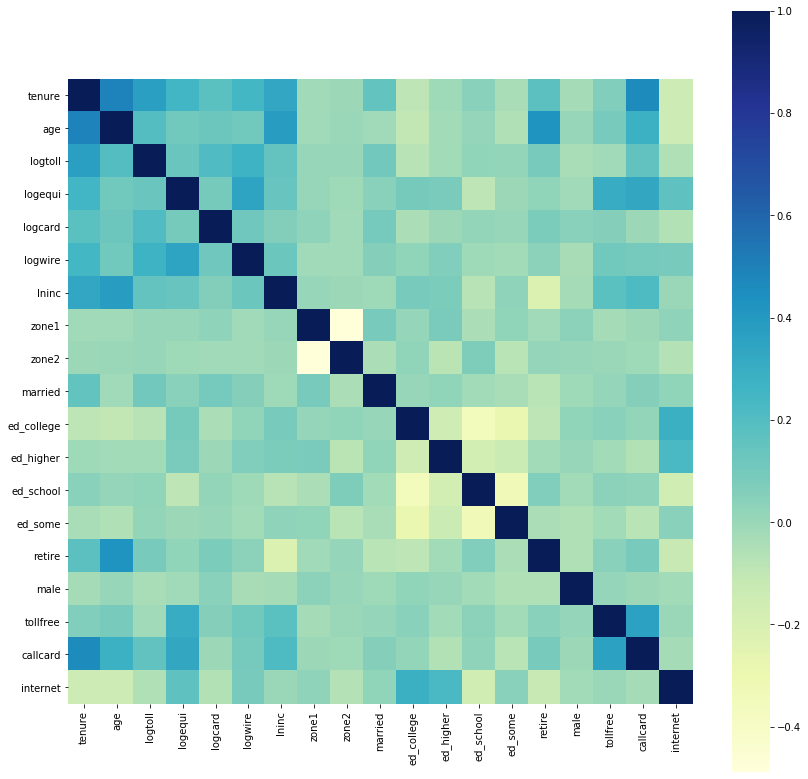

In [17]:
plt.figure(figsize=(14, 14))
sns.heatmap(data.corr(), square = True, cmap='YlGnBu')
plt.show()

In [18]:
#uncomment this to build model via formula
#categories = {'Basic' : 0, 'Total' : 1, 'Plus' : 2, 'E-service' : 3}
#data['custcat'] = data.custcat.replace(categories).astype('float64')
#print(data['custcat'].unique())
#formula_str = 'custcat ~ ' + ' + '.join(data.columns.drop('custcat'))
#print(formula_str)
#model = smf.mnlogit(formula=formula_str, data=data)
#fitted = model.fit()
#print(fitted.summary())

In [19]:
X = data.drop(columns = ['custcat']).copy()
Y = data['custcat'].copy()

In [21]:
X = sm.add_constant(X)
X.shape

(1000, 20)

In [22]:
Y.head()

0    Basic
1    Total
2     Plus
3    Basic
4     Plus
Name: custcat, dtype: category
Categories (4, object): [Basic < E-service < Plus < Total]

In [23]:
model = sm.MNLogit(Y, X)
fitted = model.fit()
print(fitted.summary())

Optimization terminated successfully.
         Current function value: 0.752881
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:                custcat   No. Observations:                 1000
Model:                        MNLogit   Df Residuals:                      940
Method:                           MLE   Df Model:                           57
Date:                Wed, 15 Apr 2020   Pseudo R-squ.:                  0.4549
Time:                        11:25:55   Log-Likelihood:                -752.88
converged:                       True   LL-Null:                       -1381.3
Covariance Type:            nonrobust   LLR p-value:                2.033e-225
custcat=E-service       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 7.3908      5.132      1.440      0.150      -2.669      17.450
tenure  

### Model description

In [24]:
params = fitted.params.copy()
params.columns=['E-service', 'Plus', 'Total']
params

,E-service,Plus,Total
const,7.390808,-9.270872,-49.790299
tenure,0.081907,0.022169,-0.002951
age,-0.025319,-0.026954,-0.040702
logtoll,-0.827332,2.329326,3.476794
logequi,-1.242515,2.494062,8.817171
logcard,0.195607,-0.007551,0.445008
logwire,-1.151521,-2.657792,0.318934
lninc,-0.063095,0.228440,0.291644
zone1,0.602812,0.444032,0.089604
zone2,0.374418,0.120636,0.342884


In [25]:
def yes_no(p_value, level = 0.05):
    if abs(p_value) < level:
        return 'yes'
    else:
        return 'no'

In [26]:
pvals = fitted.pvalues.copy()
pvals.columns = ['E-service p-value', 'Plus p-value', 'Total p-value']
pvals['E-service 5%'] = pvals['E-service p-value'].apply(yes_no)
pvals['E-service 10%'] = pvals['E-service p-value'].apply(lambda x: yes_no(x, level=0.1))
pvals['E-service p-value'] = pvals['E-service p-value'].map('{:.3f}'.format)
pvals['Plus 5%'] = pvals['Plus p-value'].apply(yes_no)
pvals['Plus 10%'] = pvals['Plus p-value'].apply(lambda x: yes_no(x, level=0.1))
pvals['Plus p-value'] = pvals['Plus p-value'].map('{:.3f}'.format)
pvals['Total 5%'] = pvals['Total p-value'].apply(yes_no)
pvals['Total 10%'] = pvals['Total p-value'].apply(lambda x: yes_no(x, level=0.1))
pvals['Total p-value'] = pvals['Total p-value'].map('{:.3f}'.format)
tuples = [(c.split(' ')[0], c.split(' ')[1]) for c in pvals.columns]
pvals.columns = pd.MultiIndex.from_tuples(tuples)
pvals = pvals.reindex(columns=pd.MultiIndex.from_tuples(sorted(tuples, key=lambda t: t[0])))
pvals

E-service              Plus             Total          
             p-value   5%  10% p-value   5%  10% p-value   5%  10%
const          0.150   no   no   0.088   no  yes   0.000  yes  yes
tenure         0.000  yes  yes   0.005  yes  yes   0.762   no   no
age            0.048  yes  yes   0.038  yes  yes   0.013  yes  yes
logtoll        0.295   no   no   0.000  yes  yes   0.000  yes  yes
logequi        0.119   no   no   0.040  yes  yes   0.000  yes  yes
logcard        0.491   no   no   0.978   no   no   0.181   no   no
logwire        0.215   no   no   0.002  yes  yes   0.729   no   no
lninc          0.735   no   no   0.246   no   no   0.206   no   no
zone1          0.028  yes  yes   0.116   no   no   0.799   no   no
zone2          0.166   no   no   0.663   no   no   0.318   no   no
married        0.934   no   no   0.294   no   no   0.119   no   no
ed_college     0.001  yes  yes   0.482   no   no   0.001  yes  yes
ed_higher      0.002  yes  yes   0.805   no   no   0.001  yes  yes
ed_school      0.090   no  yes   0.961   no   no   0.032  yes  yes
ed_some        0.001  yes  yes   0.825   no   no   0.030  yes  yes
retire         0.617   no   no   0.336   no   no   0.293   no   no
male           0.480   no   no   0.997   no   no   0.642   no   no
tollfree       0.998   no   no   0.000  yes  yes   0.000  yes  yes
callcard       0.282   no   no   0.001  yes  yes   0.000  yes  yes
internet       0.000  yes  yes   0.025  yes  yes   0.000  yes  yes

We can see that about a half of our variables **are not** statistically significant at **5%**. The level increase to 10% does not affect the results (insignificant variables remain insignificant).

### Model quality

In [27]:
pred_table = pd.DataFrame(fitted.pred_table())
pred_table.rename(columns = fitted.model._ynames_map, index=fitted.model._ynames_map, inplace=True)
pred_table

,Basic,E-service,Plus,Total
Basic,204.0,37.0,18.0,7.0
E-service,47.0,145.0,16.0,9.0
Plus,36.0,28.0,194.0,23.0
Total,7.0,17.0,39.0,173.0


In [28]:
acc = np.diag(pred_table).sum() / pred_table.sum().sum()
print('Accuracy: {:.3f}'.format(acc))

Accuracy: 0.716


**TPR**

In [29]:
tpr = np.diag(pred_table) / pred_table.sum(axis=1)
tpr

Basic        0.766917
E-service    0.668203
Plus         0.690391
Total        0.733051
dtype: float64

**Specificity**

In [30]:
specs = [pred_table.drop(columns=pred_table.columns[i], index=pred_table.index[i]).sum().sum() 
         / (pred_table.sum(axis=1).sum() - pred_table.sum(axis=1)[i]) for i in range(len(pred_table.columns))]
for (k, v) in zip(pred_table.columns, specs):
    print('{}\t\t{:.3f}'.format(k, v))

Basic		0.877
E-service		0.895
Plus		0.898
Total		0.949


In [66]:
fitted.model._ynames_map

{0: 'Basic', 1: 'E-service', 2: 'Plus', 3: 'Total'}

In [57]:
classes=['Basic', 'E-service', 'Plus', 'Total']
colors = ['darkorange', 'darkred', 'darkviolet', 'darkgreen']
y_real = label_binarize(Y, classes=classes)
y_pred = fitted.predict()

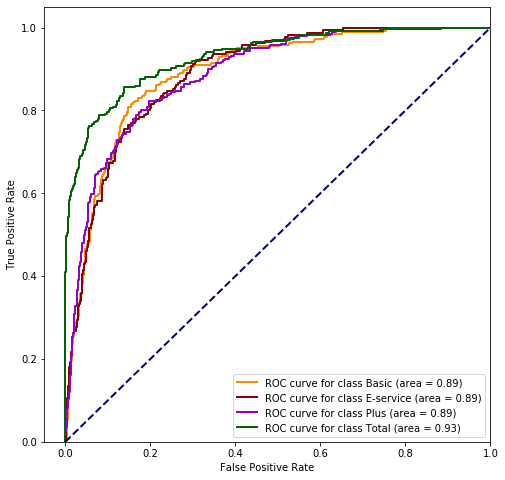

Mean AUC: 0.899


In [63]:
plt.figure(figsize=(8,8))
scores = []
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_real[:,i], y_pred[:,i])
    score = auc(fpr, tpr)
    scores.append(score)
    plt.plot(fpr, tpr, color=colors[i], lw=2, 
             label='ROC curve for class {} (area = {:.2f})'.format(classes[i], score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
print('Mean AUC: {:.3f}'.format(np.mean(scores)))

### Relative Risk Ratios

In [36]:
pd.set_option('display.float_format','{:.3f}'.format)
rrr = np.exp(params)
rrr

,E-service,Plus,Total
const,1621.015,0.000,0.000
tenure,1.085,1.022,0.997
age,0.975,0.973,0.960
logtoll,0.437,10.271,32.356
logequi,0.289,12.110,6749.147
logcard,1.216,0.992,1.561
logwire,0.316,0.070,1.376
lninc,0.939,1.257,1.339
zone1,1.827,1.559,1.094
zone2,1.454,1.128,1.409


**E-service relative to Basic:**
- The person with the higher _tenure_ is more likely to prefer E-service plan over Basic
- The person of the higher _age_ is more likely to prefer Basic plan over E-service
- _Longtoll_ increase by 1 unit decreases the relative risk for preferring E-service over Basic by factor of 0.473
- _Married_ person is less likely to prefer E-service plan over Basic
- _Retired_ person is less likely to prefer E-service plan over Basic
- If the person is _male_, he is expected to prefer Basic plan over E-service
- Having _internet_ increases the relative risk for preferring E-service plan over Basic by factor of 4.58

**Plus relative to Basic:**
- The person with the higher _tenure_ is more likely to prefer Plus plan over Basic
- The person of the higher _age_ is more likely to prefer Basic plan over Plus
- _Longtoll_ increase by 1 unit increases the relative risk for preferring Plus over Basic by factor of 10.271
- _Married_ person is more likely to prefer Plus plan over Basic
- _Retired_ person is more likely to prefer Plus plan over Basic
- If the person is *male*, he is expected to prefer Basic plan over Plus
- Having _internet_ decreases the relative risk for preferring Plus plan over Basic by factor of 0.463

**Total relative to Basic:**
- The person with the higher _tenure_ is less likely to prefer Total plan over Basic
- The person of the higher _age_ is more likely to prefer Basic plan over Total
- _Longtoll_ increase by 1 unit increases the relative risk for preferring Totla over Basic by factor of 32.356
- _Married_ person is more likely to prefer Total plan over Basic
- _Retired_ person is more likely to prefer Total plan over Basic
- If the person is *male*, he is expected to prefer Total plan over Basic
- Having _internet_ increases the relative risk for preferring Total plan over Basic by factor of 7.573

### Confusion matrix

Text(0.5, 257.44, 'Predicted label')

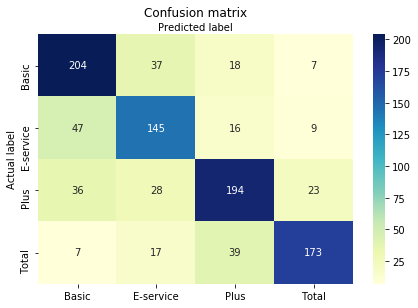

In [31]:
names = pred_table.columns
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))
plt.xticks(tick_marks, names)
plt.yticks(tick_marks, names)
sns.heatmap(pred_table, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [32]:
for cat in names:
    pred = pred_table[cat][cat]
    total = (Y == cat).sum()
    print('{} category: predicted correctly {} out of {} ({:.2f})%'
          .format(cat, pred, total, 100 * pred / total))

Basic category: predicted correctly 204.0 out of 266 (76.69)%
E-service category: predicted correctly 145.0 out of 217 (66.82)%
Plus category: predicted correctly 194.0 out of 281 (69.04)%
Total category: predicted correctly 173.0 out of 236 (73.31)%


_Basic_ category was predicted in the best way.

### Case analysis

In [33]:
df.loc[10]

region          Zone2
tenure              5
age                33
marital     Unmarried
address            10
income            125
ed            college
employ              5
retire             No
gender         Female
reside              1
tollfree           No
equip             Yes
callcard           No
wireless           No
longmon          4.85
tollmon             0
equipmon        26.15
cardmon             0
wiremon             0
longten         17.25
tollten             0
equipten        110.1
cardten             0
wireten             0
multline           No
voice              No
pager             Yes
internet          Yes
callid             No
callwait           No
forward            No
confer             No
ebill             Yes
loglong       1.57898
logtoll       3.23971
logequi       3.26385
logcard       2.85421
logwire        3.5983
lninc         4.82831
custcat         Basic
churn             Yes
Name: 10, dtype: object

The person belongs to __Basic__ category according to our dataset

In [34]:
predicted = fitted.predict(X.iloc[10].values)[0]
for i in range(len(predicted)):
    print('{:.3f} probability of {} class'.format(predicted[i], names[i]))

0.607 probability of Basic class
0.353 probability of E-service class
0.014 probability of Plus class
0.026 probability of Total class


In [35]:
print(predicted.argmax())
names[predicted.argmax()]

0


'Basic'

The model predicted __Basic__ class for the person from 10th case (the prediction is correct)